# Imports

In [6]:
#!pip install tensorflow==2.9.1
#!pip install tensorflow_addons
#!pip install keras
#!pip install sklearn
#!pip install livelossplot
#!pip install tqdm
#!pip install pandas
#!pip install joblib
#!pip install dill
#!pip install pickle
#!pip install seaborn
#!pip install scipy
#!pip install genetic-tree
#!pip install numba
#!pip install tabulate

In [7]:
config = {
    'gdt': {
        'depth': 5,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0,
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 512,
        'epochs': 1,#10_000
        
        'restarts': 10,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '5',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        
    },
    
    'benchmarks': {
        'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [4]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2022-11-20--11-21-10841725


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


# Evaluation

## make_classification

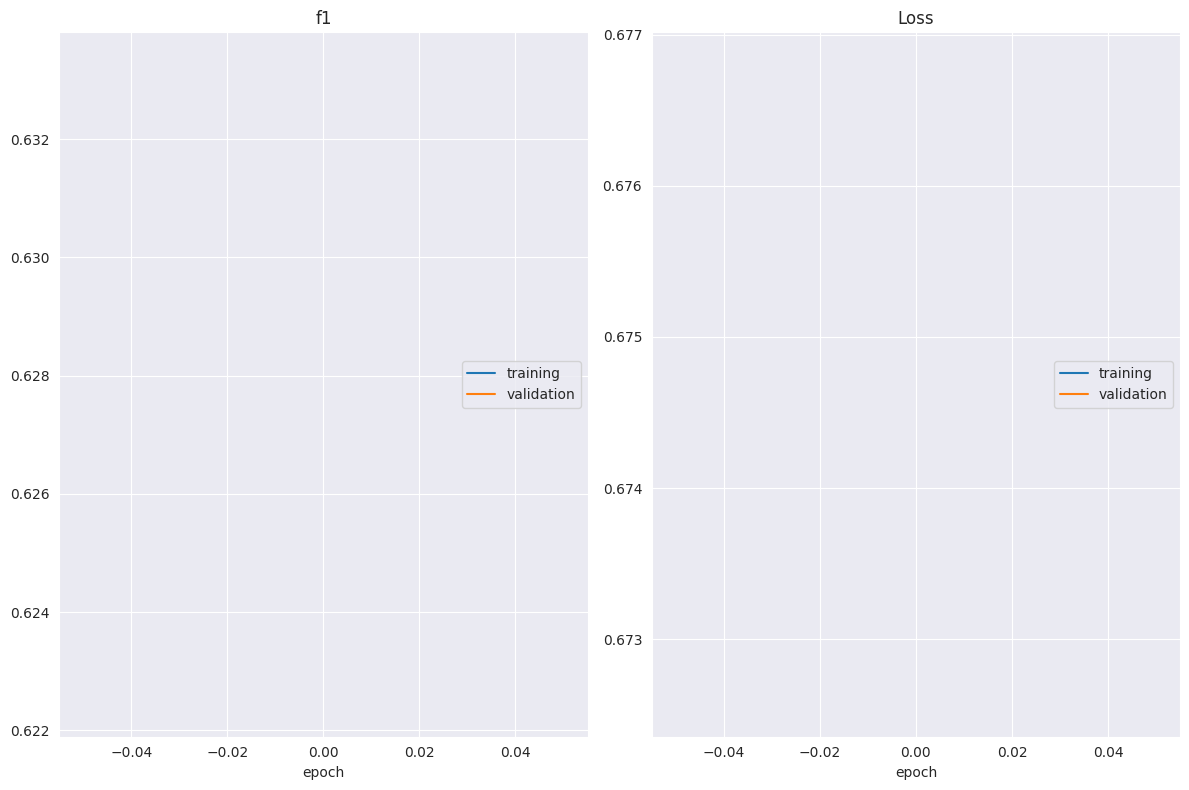

f1
	training         	 (min:    0.633, max:    0.633, cur:    0.633)
	validation       	 (min:    0.622, max:    0.622, cur:    0.622)
Loss
	training         	 (min:    0.673, max:    0.673, cur:    0.673)
	validation       	 (min:    0.677, max:    0.677, cur:    0.677)
Test f1 GDT (0) 0.5902083333333333
Test roc_auc GDT (0) 0.5093761269383339
Test accuracy GDT (0) 0.62
________________________________________________________________________________________________________
Test f1 sklearn (0) 0.7631977559607293
Test roc_auc sklearn (0) 0.726289217454021
Test accuracy sklearn (0) 0.76
________________________________________________________________________________________________________


In [8]:


dataset_dict, config_training, metrics = prepare_training(identifier = 'BIN:German', config = config)

model_dict = {}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = dataset_dict['number_of_variables'],
            number_of_classes = dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)#5      


history = model_dict['GDT'].fit(dataset_dict['X_train'],
          dataset_dict['y_train'],

          batch_size=config_training['gdt']['batch_size'], 
          epochs=config_training['gdt']['epochs'], 

          restarts = 0,#config_test['gdt']['restarts'], 
          #restart_type=config_test['gdt']['restart_type'], 

          #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
          #early_stopping_type=config_test['gdt']['early_stopping_type'],

          valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
                                      random_state=config_training['computation']['random_seed'])

model_dict['sklearn'].fit(dataset_dict['X_train'], 
                          dataset_dict['y_train'])


# model_dict['GeneticTree'] = GeneticTree()
# model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
#                                                           dataset_dict['y_train'].values)        


scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict, 
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           

#model.set_params(**config_training['gdt'])   

In [74]:
if False:#if False and config['gdt']['objective'] == 'classification':
    normalizer_list = dataset_dict['normalizer_list']
    if normalizer_list is not None: 
        transpose_normalized = []
        for i, column_name in enumerate(dataset_dict['X_train']):
            column = deepcopy(dataset_dict['X_train'][column_name])
            column_new = column
            if len(column_new[column_new != 0]) != 0:
                column_new[column_new != 0] = normalizer_list[i].inverse_transform([column[column != 0]])
                #column_new = normalizer_list[i].inverse_transform(column.reshape(-1, 1)).ravel()
            transpose_normalized.append(column_new)
        data = pd.DataFrame(np.array(transpose_normalized).transpose(), columns=dataset_dict['X_train'].columns).round(1)
        display(data.head())        
    
    plt.figure(figsize=(15,8))
    image = model_dict['GDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

## Real-World Eval

### Classification

In [75]:
identifier_list_classification_binary = [
                        'BIN:Blood Transfusion',# 748 4
                        'BIN:Banknote Authentication',# 1372 4
                        'BIN:Titanic',# 891 7 
                        'BIN:Raisins',#900 7
                        'BIN:Rice',#3810 7
                        'BIN:Echocardiogram',#132 8 ###TD
                        'BIN:Wisconsin Diagnostic Breast Cancer',# 569 10
                        'BIN:Loan House',# 614 11
                        'BIN:Heart Failure',# 299 12
                        'BIN:Heart Disease',# 303 13
                        'BIN:Adult',# 32561 14
                        'BIN:Bank Marketing',# 45211 14
                        'BIN:Cervical Cancer',# 858 15
                        'BIN:Congressional Voting',# 435, 16 ###TD
                        'BIN:Absenteeism',# 740 18
                        'BIN:Hepatitis',#155 19 ###TD
                        'BIN:German',# 1000 20
                        'BIN:Mushroom',#8124 22
                        'BIN:Credit Card',# 30000 23
                        'BIN:Horse Colic',#368 27
                        'BIN:Thyroid',#9172 29 ###TD
                        'BIN:Spambase',# 4601 57
                  ]       

In [9]:

#benchmark_dict = get_benchmark_dict(config=config, eval_identifier='classification') 

#parallel_eval_real_world = Parallel(n_jobs=min(config['computation']['n_jobs'], config['computation']['trials']), verbose=3, backend='loky') #loky #sequential multiprocessing
#evaluation_results_real_world_classification_binary = parallel_eval_real_world(delayed(evaluate_real_world_parallel_nested)(identifier_list=identifier_list_classification_binary[::-1], 
                                                                                                                           random_seed_data=config['computation']['random_seed']+i,
                                                                                                                           random_seed_model=config['computation']['random_seed'],
                                                                                                                           config = config,
                                                                                                                           benchmark_dict = benchmark_dict,
                                                                                                                           metrics = config['computation']['metrics_class'],
                                                                                                                           verbosity = -1) for i in range(config['computation']['trials']))


IndentationError: unexpected indent (3080332066.py, line 5)

In [ ]:
plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_binary,
                        identifier_list=identifier_list_classification_binary,                            
                        identifier_string='binary_test',
                        filepath=filepath,
                        config=config)      

plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_binary,
                        identifier_list=identifier_list_classification_binary,                            
                        identifier_string='binary_valid',
                        filepath=filepath,
                        config=config)  

plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_binary,
                        identifier_list=identifier_list_classification_binary,                            
                        identifier_string='binary_train',
                        filepath=filepath,
                        config=config)  

In [ ]:
if False:#if False and config['gdt']['objective'] == 'classification':
    plot_dt_comparison(evaluation_results_real_world=evaluation_results_real_world_classification_binary,
                      identifier_list=identifier_list_classification_binary,
                      identifier_string='binary_test',
                      timestr=timestr,
                      config=config)

In [ ]:
identifier_list_classification_multi = [
                        'MULT:Iris',# 150 4 3
                        'MULT:Balance Scale',# 625 4 3
                        'MULT:Car',# 1728 6 4
                        'MULT:Glass',# 214 9 6 
                        'MULT:Contraceptive',# 1473 9 3 
                        'MULT:Solar Flare',# 1389 10 8
                        'MULT:Wine',# 178 12 3
                        'MULT:Zoo',#101 16 7   ###TD
                        'MULT:Lymphography',# 148 18 4 ###TD
                        'MULT:Segment',# 2310 19 7
                        'MULT:Dermatology',# 366 34 6
                        'MULT:Landsat',# 6435 36 6
                        'MULT:Annealing',# 798 38 5
                        'MULT:Splice',# 3190 60 3
                  ]       

In [ ]:

benchmark_dict = get_benchmark_dict(config=config, eval_identifier='classification')

metrics = ['f1', 'roc_auc', 'accuracy']

parallel_eval_real_world = Parallel(n_jobs=min(config['computation']['n_jobs'], config['computation']['trials']), verbose=3, backend='loky') #loky #sequential multiprocessing
evaluation_results_real_world_classification_multi = parallel_eval_real_world(delayed(evaluate_real_world_parallel_nested)(identifier_list=identifier_list_classification_multi[::-1], 
                                                                                                       random_seed_data=config['computation']['random_seed']+i,
                                                                                                       random_seed_model=config['computation']['random_seed'],
                                                                                                       config = config,
                                                                                                       benchmark_dict = benchmark_dict,
                                                                                                       metrics = config['computation']['metrics_class'],
                                                                                                       verbosity = -1) for i in range(config['computation']['trials']))


In [ ]:
plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_multi,
                        identifier_list=identifier_list_classification_multi,                            
                        identifier_string='multi_test',
                        filepath=filepath,
                        config=config)      

plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_multi,
                        identifier_list=identifier_list_classification_multi,                            
                        identifier_string='multi_valid',
                        filepath=filepath,
                        config=config)  

plot_table_save_results(benchmark_dict=benchmark_dict,
                        evaluation_results_real_world=evaluation_results_real_world_classification_multi,
                        identifier_list=identifier_list_classification_multi,                            
                        identifier_string='multi_train',
                        filepath=filepath,
                        config=config)  

In [ ]:
if False:#if False and config['gdt']['objective'] == 'classification':
    plot_dt_comparison(evaluation_results_real_world=evaluation_results_real_world_classification_multi,
                      identifier_list=identifier_list_classification_multi,
                      identifier_string='multi_test',
                      timestr=timestr,
                      config=config)

In [ ]:
from numba import cuda 
if config['computation']['use_gpu']:
    device = cuda.get_current_device()
    device.reset()

In [1]:
!pip list


Package                      Version
---------------------------- --------------
absl-py                      1.3.0
appdirs                      1.4.4
asttokens                    2.0.8
astunparse                   1.6.3
attrs                        20.3.0
backcall                     0.2.0
beautifulsoup4               4.9.3
bokeh                        2.4.3
Bottleneck                   1.3.2
cachetools                   5.2.0
ceph                         1.0.0
cephfs                       2.0.0
certifi                      2020.6.20
chardet                      4.0.0
cloudpickle                  2.2.0
contourpy                    1.0.5
cvxpy                        1.2.1
cycler                       0.11.0
Cython                       3.0a6
debugpy                      1.6.3
decorator                    4.4.2
defusedxml                   0.6.0
dill                         0.3.6
distlib                      0.3.1
dm-tree                      0.1.7
ecos                         2.0.10
en